In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import radon
from skimage.data import binary_blobs
from skimage.draw import disk

The Radon transform is available in Python as `radon` in the `skimage.transform` library. To study the ill-posedness of the inverse problem, we first build an explicit matrix representation of the Radon transform in `getK`.

1. Construct the matrix for `nx = 32` and plot the left and right singular vectors and singular values.
2. Generate noisy data and apply the regularised pseudo-inverse, selecting an appropriate regularisation parameter for various noise levels
3. Explain how regularisation both reduces noise and limits the resolution of the resulting image
4. Can you think of a type of noise for which the usual regularisation will not work?

In [38]:
def getK(nx):
    """
    Get explicit matrix representation of the Radon transform for an nx by nx image.
    
    input:
        nx - dimension of the input image
        theta - array with angles (in degrees)
        
    output:
        K - matrix of size nd*nt by nx*nx, with nd = int(np.sqrt(2)*nx)+1
    """
    theta = np.linspace(0,180,nx)
    nd = int(np.sqrt(2)*nx)+1
    N = nx**2
    M = nd*nx
    K = np.zeros((M,N))
    for i in range(nx**2):
        ei = np.zeros(nx**2)
        ei[i] = 1
        K[:,i] = radon(np.reshape(ei,(nx,nx)), theta=theta, circle = False).ravel()
    return K

def getPhantom(nx, r = 0.9):
    """
    Define phantom image.
    
    input:
        nx - dimension of the input image
        r - radius of phantom, optional (default = 0.9)
    
    output:
        u - phantom image as 1d array of length nx*nx
    """
    # mask
    mask = np.zeros((nx,nx))
    ii,jj = disk((nx//2,nx//2),r * (nx//2))
    mask[ii,jj] = 1
    
    # binary blobs
    u = 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.2))
    u *= mask
    
    # return
    return u.ravel()
    
def plot_image(u,nx,ax=[],title=''):
    """
    plot image
    """
    
    if not ax:
        fig, ax = plt.subplots()
    
    ax.imshow(u.reshape((nx,nx)),extent=(0,1,0,1))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(title)
    
def plot_sinogram(f,nx,ax=[],title=''):
    """
    plot sinogram
    """
    nd = len(f) // nx
    
    if not ax:
        fig, ax = plt.subplots()
        
    ax.imshow(f.reshape((nd,nx)),extent=(0,3.14,0,1.5))
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$s$')
    ax.set_title(title)
    
    ax.set_aspect(2)

In [39]:
# settings
nx = 32

# get matrix
K = getK(nx)

# get phantom
u = getPhantom(nx)

# generate data
f = K@u

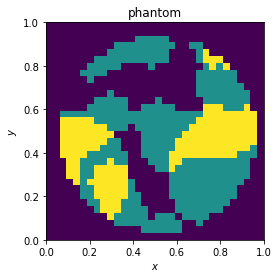

In [40]:
plot_image(u,nx,title='phantom')

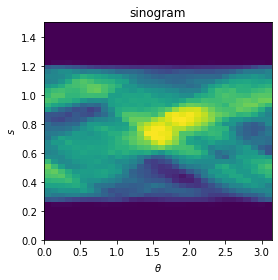

In [41]:
plot_sinogram(f,nx,title='sinogram')

# 1
We can easily compute the SVD of $K$, as before. To visualise the singular vectors, we need to keep in mind that they are either images or sinograms.

We see that the singular values decay slowly at first and faster from index 700 onwards. 

We see that the right singular vectors are oscilatory with increasingly high frequencies in the $x$ and $y$ directions. The left singular vectors are the corresponding sinograms. 


In [13]:
# compute svd
U,s,Vh = np.linalg.svd(K,full_matrices=True)

Text(0, 0.5, '$\\sigma_i$')

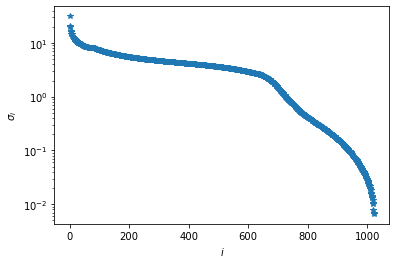

In [15]:
# singular values
plt.semilogy(s,'*')
plt.xlabel(r'$i$')
plt.ylabel(r'$\sigma_i$')

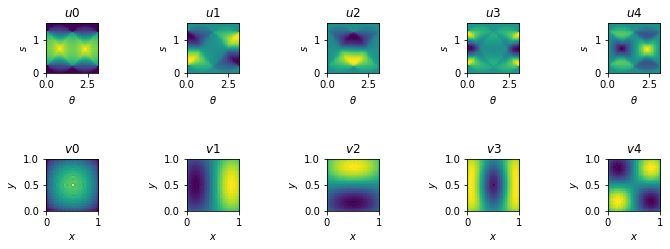

In [55]:
# left and right singular vectors
fig, ax = plt.subplots(2,5)

for i in range(5):
    plot_sinogram(U[:,i],nx,ax[0,i],title=r'$u$'+str(i))
    plot_image(Vh[i,:],nx,ax[1,i],title=r'$v$'+str(i))
fig.tight_layout()
fig.set_figwidth(10)

# 2

We observe that for higher alpha we get less noisy, but also less details in the image.

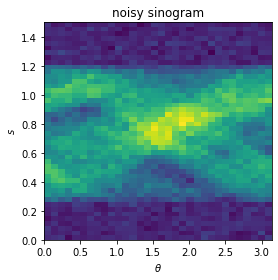

In [81]:
# generate noisy data
delta = 1
f_delta = f + delta*np.random.randn(len(f)) 

plot_sinogram(f_delta,nx,title='noisy sinogram')

In [82]:
# regularised pseudo inverse
u_hat = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U[:,:nx**2].T@f_delta

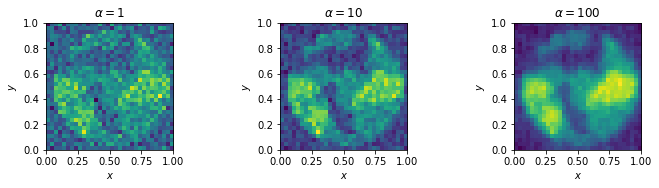

In [83]:
# reconstruction for different alpha
alphas = [1,10,100]

fig, ax = plt.subplots(1,len(alphas))
for i in range(len(alphas)):
    plot_image(u_hat(alphas[i]),nx,ax[i],title=r'$\alpha=$'+str(alphas[i]))
fig.tight_layout()
fig.set_figwidth(10)

reconstruction error =  4.926715132174701


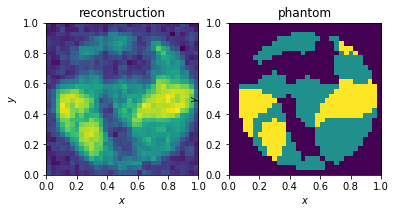

In [59]:
alpha = 50
ur = u_hat(alpha)

fig, ax = plt.subplots(1,2)

plot_image(ur,nx,ax[0],title='reconstruction')
plot_image(u,nx,ax[1],title='phantom')

print('reconstruction error = ', np.linalg.norm(ur - u))

# 3

The final result is a sum of various terms:

$$u = \sum_i w_i v_i,$$

with

$$w_i = \left(\frac{\sigma_i}{\sigma_i^2 + \alpha}\right) \langle u_i, f_{\delta}\rangle.$$

We have seen that the right singular vectors get increasingly oscilatory for smaller singular values. At the same time, we observe that noise mainly shows up in coefficients corresponding to small singular values and that regularisation damps these contributions.

We can see this more clearly when comparing the noisless coefficients $\langle u_i, f\rangle / \sigma_i$ to the noisy, regularised ones.

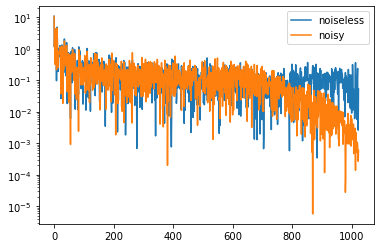

In [87]:
alpha = 10
weights = np.diag(s/(s**2 + 1e-16))@U[:,:nx**2].T@f
weights_delta = np.diag(s/(s**2 + alpha))@U[:,:nx**2].T@f_delta

plt.semilogy(np.abs(weights),label='noiseless')
plt.semilogy(np.abs(weights_delta),label='noisy')

plt.legend()

# 4

The regularisation we perform removes contributions related to small singular values. If the noise happens to correspond to the large singular values, we cannot remove them in this fashion. An example would be a constant offset of the intesities of the sinogram.

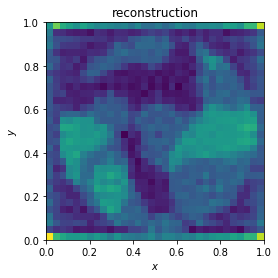

In [133]:
f_offset = f + 1e1*np.ones(len(f))

u_hat = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U[:,:nx**2].T@f_offset

alpha = 10
plot_image(u_hat(alpha),nx,title='reconstruction')